In [7]:
import pickle
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import load_model as keras_load_model

In [8]:
# Load data for a specific stock
def load_data(ticker, start_date='2010-01-01', end_date='2023-01-01'):
    return yf.download(ticker, start=start_date, end=end_date)

In [9]:
# Preprocess the data (normalization and creating sequences)
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    
    sequence_length = 60
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)  # 80% for training
    return X[:split], y[:split], X[split:], y[split:], scaler

In [10]:
# Model building
def build_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [11]:
# Save the trained model and scaler to a file
def save_model(model, scaler, stock_name, filename):
    model.save(filename)  # Save the Keras model separately
    with open(f"{stock_name}_scaler.pkl", 'wb') as file:
        pickle.dump(scaler, file)  # Save the scaler in a separate file
    print(f"Model and scaler saved as {filename} and {stock_name}_scaler.pkl")

In [12]:
# Load the model and scaler from file
def load_model(stock_name, model_filename):
    model = keras_load_model(model_filename)
    with open(f"{stock_name}_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)
    return model, scaler

In [13]:
# Predict future stock price based on latest data
def predict_next_day(model, scaler, data, sequence_length=60):
    data_scaled = scaler.transform(data['Close'].values.reshape(-1, 1))
    X_input = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
    scaled_prediction = model.predict(X_input)
    prediction = scaler.inverse_transform(scaled_prediction)
    return prediction[0][0]  # Return the unscaled prediction value

In [14]:
# Plotting the predicted vs actual stock prices
def plot_predictions(actual, predicted, stock_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, color='blue', label='Actual Price')
    plt.plot(predicted, color='red', label='Predicted Price')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [15]:
# Evaluate model performance
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, mae, r2

In [18]:
# Train and save model for a given stock
def train_and_save_model(stock_ticker):
    # Load data
    data = load_data(stock_ticker)
    
    # Preprocess data
    X_train, y_train, X_test, y_test, scaler = preprocess_data(data)
    
    # Build the model
    model = build_model((X_train.shape[1], 1))
    
    # Train the model
    model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)
    
    # Save the model and scaler
    save_model(model, scaler, stock_ticker, f"{stock_ticker}_model.h5")

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)  # Unscale predictions
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Unscale actual test data
    
    # Plot predictions vs actual values
    plot_predictions(y_test_actual, y_pred, stock_ticker)
    
    # Evaluate model performance
    mse, rmse, mae, r2 = evaluate_model(y_test_actual, y_pred)
    print(f"Performance metrics for {stock_ticker}:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # Predict next day's stock price for the given stock
    next_day_prediction = predict_next_day(model, scaler, data)
    print(f"Predicted next day's stock price for {stock_ticker}: {next_day_prediction}")

[*********************100%***********************]  1 of 1 completed

Epoch 1/15



c:\Users\aksha\Desktop\Stock_Prediction_app\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0145 - val_loss: 2.6727e-04
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.8155e-04 - val_loss: 4.1043e-04
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.2873e-04 - val_loss: 2.4422e-04
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.0950e-04 - val_loss: 3.3498e-04
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.7881e-04 - val_loss: 2.5543e-04
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.4547e-04 - val_loss: 2.3360e-04
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.1794e-04 - val_loss: 5.6595e-04
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.8908e-04 - val_loss: 2.8219e-04
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7373e-04 - val_loss: 2.3387e-04
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.3637e-04 - val_loss: 2.2742e-04
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.1414e-04 - val_loss: 2

Model and scaler saved as TCS.NS_model.h5 and TCS.NS_scaler.pkl
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


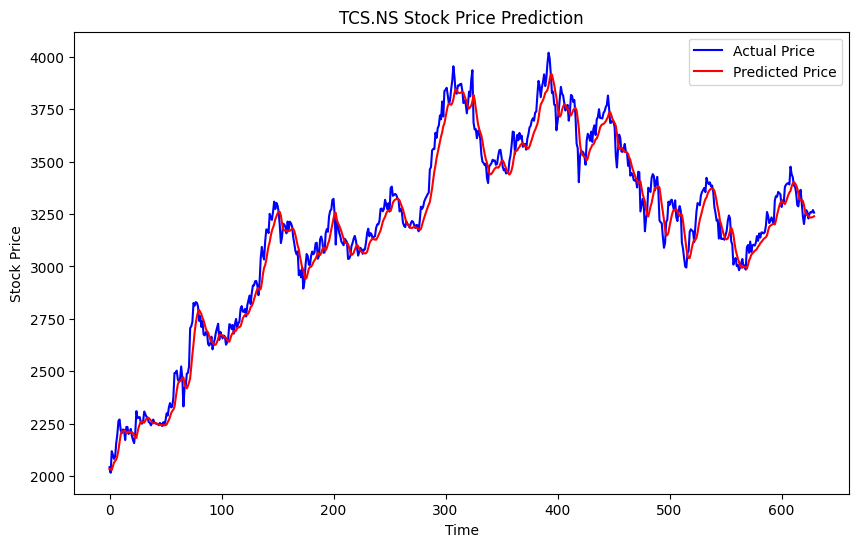

Performance metrics for TCS.NS:
Mean Squared Error (MSE): 4912.900194856548
Root Mean Squared Error (RMSE): 70.09208368180067
Mean Absolute Error (MAE): 55.21796468098958
R-squared (R²): 0.9749410309281067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[*********************100%***********************]  1 of 1 completed

Predicted next day's stock price for TCS.NS: 3240.3818359375
Epoch 1/15



c:\Users\aksha\Desktop\Stock_Prediction_app\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0032 - val_loss: 2.5264e-04
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.7535e-04 - val_loss: 6.2465e-04
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.5140e-04 - val_loss: 2.3028e-04
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.9801e-04 - val_loss: 2.7996e-04
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.8262e-04 - val_loss: 2.2136e-04
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.7099e-04 - val_loss: 2.2709e-04
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.4450e-04 - val_loss: 1.9918e-04
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.5340e-04 - val_loss: 1.9794e-04
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.4085e-04 - val_loss: 1.9728e-04
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.1501e-04 - val_loss: 2.6318e-04
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.3793e-04 - val_loss: 1

Model and scaler saved as INFY.NS_model.h5 and INFY.NS_scaler.pkl
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


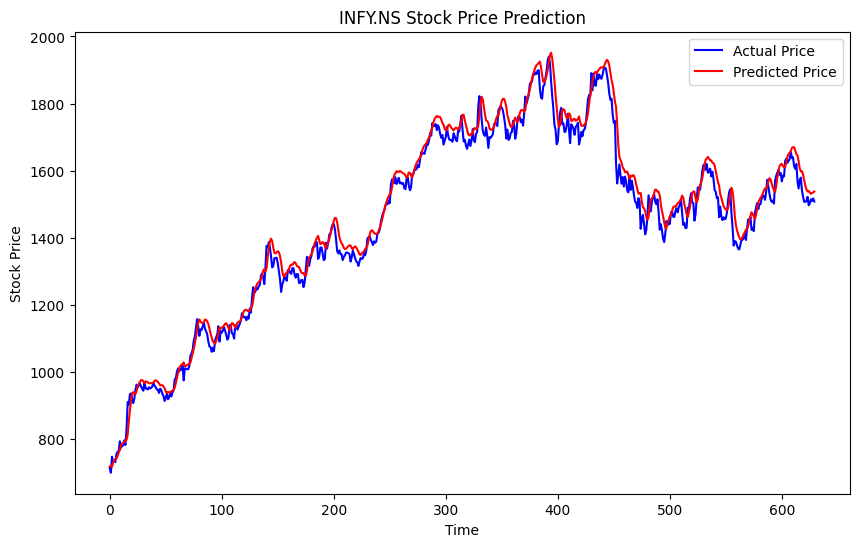

Performance metrics for INFY.NS:
Mean Squared Error (MSE): 1452.1227627603903
Root Mean Squared Error (RMSE): 38.106728575940366
Mean Absolute Error (MAE): 29.127223617311515
R-squared (R²): 0.9811588325750369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed

Predicted next day's stock price for INFY.NS: 1537.971435546875
Epoch 1/15



c:\Users\aksha\Desktop\Stock_Prediction_app\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0221 - val_loss: 6.2179e-04
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0011 - val_loss: 8.1169e-04
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.6688e-04 - val_loss: 6.0512e-04
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.9162e-04 - val_loss: 7.5503e-04
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.0136e-04 - val_loss: 5.7397e-04
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.1278e-04 - val_loss: 5.7433e-04
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.8098e-04 - val_loss: 5.7309e-04
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.2906e-04 - val_loss: 6.4245e-04
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.1862e-04 - val_loss: 6.2919e-04
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.2357e-04 - val_loss: 5.8966e-04
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 6.1478e-04 - val_loss: 6.542

Model and scaler saved as HDFCBANK.NS_model.h5 and HDFCBANK.NS_scaler.pkl
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


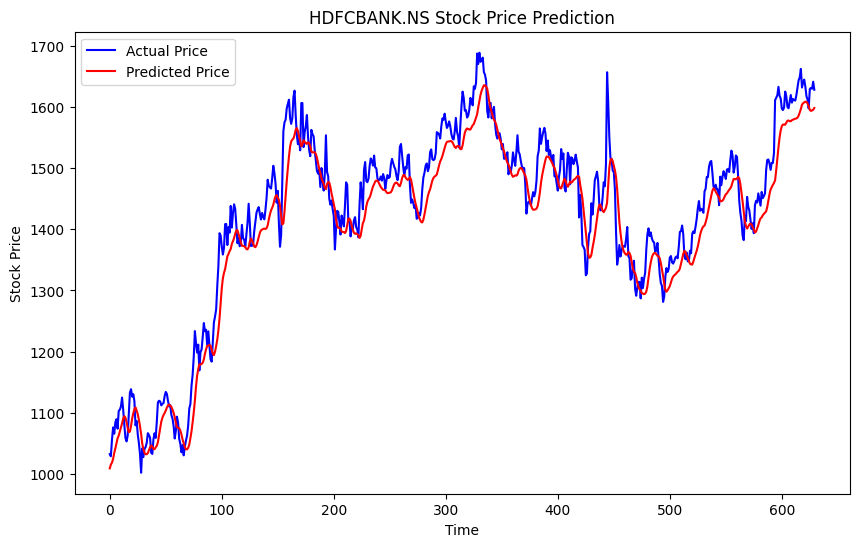

Performance metrics for HDFCBANK.NS:
Mean Squared Error (MSE): 1913.9021727540367
Root Mean Squared Error (RMSE): 43.74816765024607
Mean Absolute Error (MAE): 34.753580826047866
R-squared (R²): 0.9222805978382791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[*********************100%***********************]  1 of 1 completed

Predicted next day's stock price for HDFCBANK.NS: 1599.512451171875
Epoch 1/15



c:\Users\aksha\Desktop\Stock_Prediction_app\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0241 - val_loss: 2.1855e-04
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0025 - val_loss: 3.2084e-04
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0020 - val_loss: 2.0850e-04
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - val_loss: 1.9927e-04
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016 - val_loss: 1.9874e-04
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016 - val_loss: 3.2881e-04
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014 - val_loss: 1.9344e-04
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017 - val_loss: 1.8427e-04
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013 - val_loss: 1.7593e-04
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014 - val_loss: 7.8858e-04
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013 - val_loss: 5.6673e-04
Epoch 12/15
71/71 ━━━━━━━━━━━━

Model and scaler saved as SUNPHARMA.NS_model.h5 and SUNPHARMA.NS_scaler.pkl
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


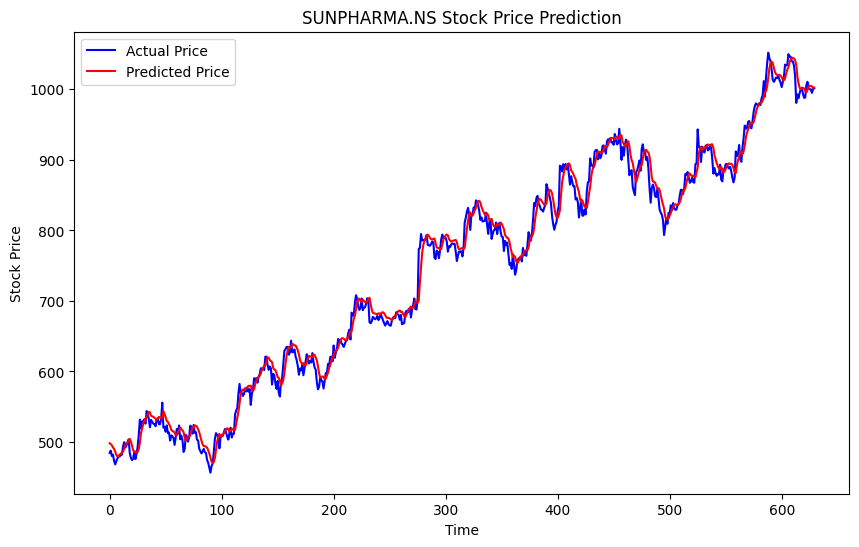

Performance metrics for SUNPHARMA.NS:
Mean Squared Error (MSE): 230.40042383790995
Root Mean Squared Error (RMSE): 15.178946730188823
Mean Absolute Error (MAE): 11.587471468486486
R-squared (R²): 0.9913998654678372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed

Predicted next day's stock price for SUNPHARMA.NS: 1003.3108520507812
Epoch 1/15



c:\Users\aksha\Desktop\Stock_Prediction_app\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0568 - val_loss: 0.0056
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0031 - val_loss: 7.5535e-04
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0027 - val_loss: 4.4602e-04
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0025 - val_loss: 6.5508e-04
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0023 - val_loss: 4.7262e-04
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0022 - val_loss: 4.2339e-04
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0021 - val_loss: 7.1645e-04
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0019 - val_loss: 2.7919e-04
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0021 - val_loss: 4.1138e-04
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0020 - val_loss: 8.0930e-04
Epoch 12/15
71/71 ━━━━━━━━━━━━━━━━━━━━

Model and scaler saved as ONGC.NS_model.h5 and ONGC.NS_scaler.pkl
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


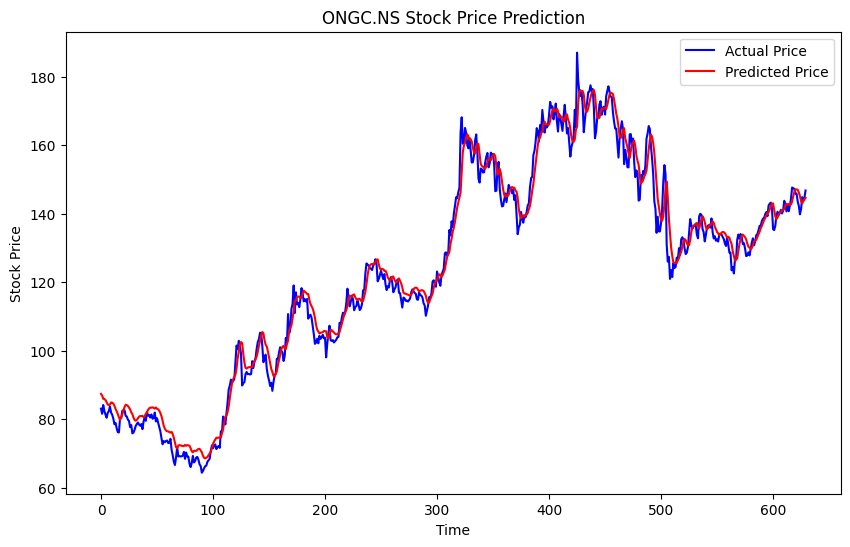

Performance metrics for ONGC.NS:
Mean Squared Error (MSE): 17.51649230696069
Root Mean Squared Error (RMSE): 4.1852708761752435
Mean Absolute Error (MAE): 3.110344490172371
R-squared (R²): 0.9816697241999237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[*********************100%***********************]  1 of 1 completed

Predicted next day's stock price for ONGC.NS: 145.58738708496094
Epoch 1/15



c:\Users\aksha\Desktop\Stock_Prediction_app\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0118 - val_loss: 8.4330e-04
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.2360e-04 - val_loss: 6.0210e-04
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.6680e-04 - val_loss: 6.1381e-04
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.9639e-04 - val_loss: 5.9278e-04
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.9543e-04 - val_loss: 5.8623e-04
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.4528e-04 - val_loss: 7.1232e-04
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 5.1677e-04 - val_loss: 6.6139e-04
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.9553e-04 - val_loss: 8.9710e-04
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.8165e-04 - val_loss: 8.5131e-04
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.3490e-04 - val_loss: 5.8500e-0

Model and scaler saved as HINDUNILVR.NS_model.h5 and HINDUNILVR.NS_scaler.pkl
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


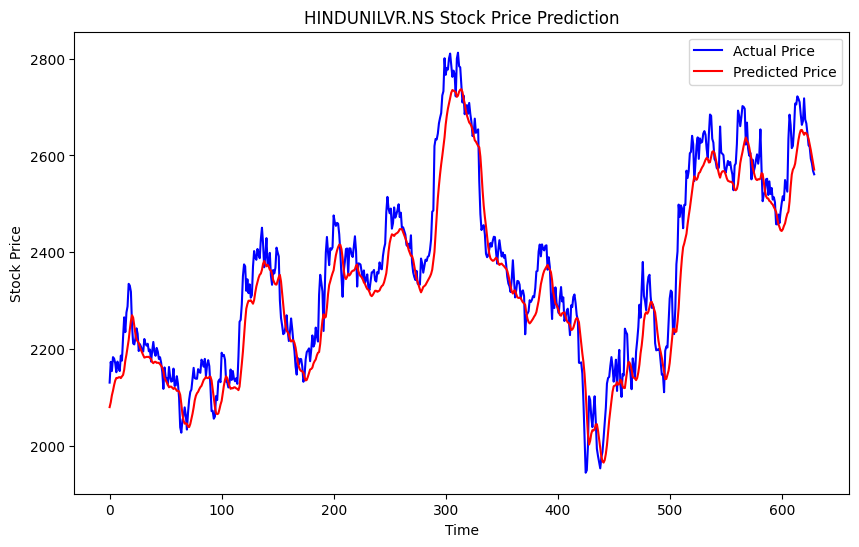

Performance metrics for HINDUNILVR.NS:
Mean Squared Error (MSE): 3580.8842646678586
Root Mean Squared Error (RMSE): 59.840490177369524
Mean Absolute Error (MAE): 46.35723218160969
R-squared (R²): 0.9033762676716905
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted next day's stock price for HINDUNILVR.NS: 2558.173095703125


In [19]:
# Example for multiple stocks
stocks = ['TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'SUNPHARMA.NS', 'ONGC.NS', 'HINDUNILVR.NS']
for stock in stocks:
    train_and_save_model(stock)